# Visualizing Dense layer using ActivationMaximization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_dense_layer.ipynb)
[![Right click and save](https://img.shields.io/badge/Notebook-Open_In_Github-orange.svg)](https://github.com/keisen/tf-keras-vis/blob/master/docs/examples/visualize_dense_layer.ipynb)


Preparation
-----------

### Load libraries

In [1]:
!pip install tf-keras-vis

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
from tf_keras_vis.activation_maximization.callbacks import Progress, PrintLogger

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

In this notebook, we use VGG16 model, however if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Implement functions required to use ActivationMaximization

### Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the actiation maps, so you should replace the function to a linear activation function. Here, we create and use `ReplaceToLinear` instance.

In [4]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer

replace2linear = ReplaceToLinear()

# Instead of using ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Score function

You **MUST** create `Score` instance or define `score function` that returns arbitrary category value. Here, our socre function returns the value corresponding to No.20 (Ouzel) of imangenet.

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

# 20 is the imagenet index corresponding to Ouzel.
scores = CategoricalScore([292, 309, 817])
seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)
image_titles = ['Tiger', 'Bee', 'Car']

## Visualizing a specific output category

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, however the process may take a while.

In [6]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("predictions"), ReplaceToLinear()],
                                                 clone=True)

200/200 [==============================] - 33s 122ms/step - Score: 66.3296 - TotalVariation2D: 6.4010 - Norm: 38.0728


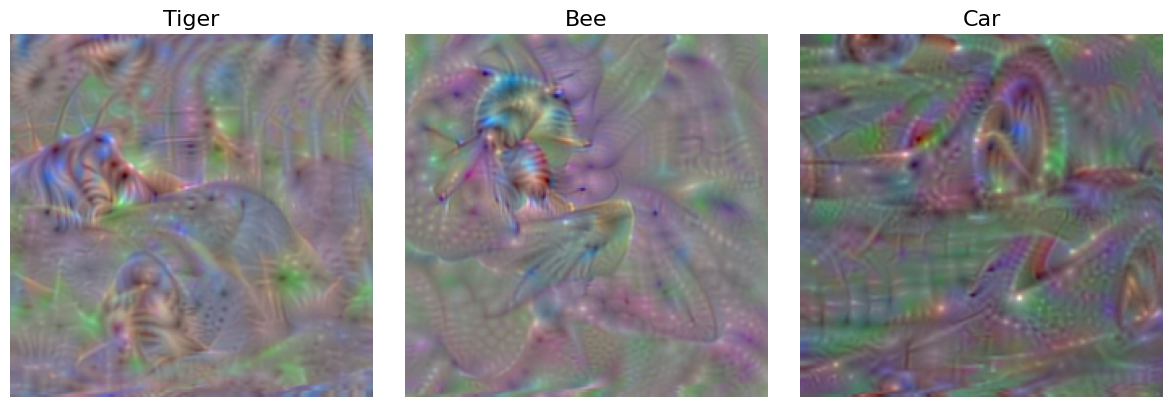

CPU times: user 27.2 s, sys: 1.62 s, total: 28.8 s
Wall time: 36.2 s


In [7]:
# original
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=replace2linear,
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    normalized_image = activations[i] - np.min(activations[i])
    normalized_image /= np.max(normalized_image)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(normalized_image)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Visualize

ActivationMaximization will maximize the output of the score function. Here, as a result, we will get a visualized image that maximizes the model output corresponding to the No.20 (Ouzel) of imagenet.

200/200 [==============================] - 28s 139ms/step - Score: 439.6303 - TotalVariation2D: 10.9164 - Norm: 38.4323


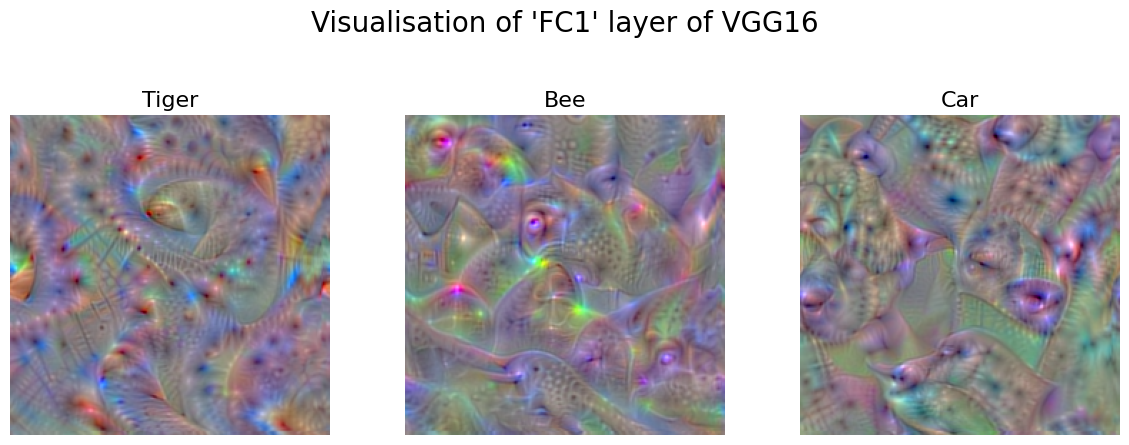

CPU times: user 24.8 s, sys: 1.3 s, total: 26.1 s
Wall time: 30.2 s


In [8]:
# fc1
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("fc1"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
f.suptitle("Visualisation of 'FC1' layer of VGG16", y=1.1, fontsize=20)
for i, title in enumerate(image_titles):
    normalized_image = activations[i] - np.min(activations[i])
    normalized_image /= np.max(normalized_image)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(normalized_image)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

200/200 [==============================] - 25s 122ms/step - Score: 46.1943 - TotalVariation2D: 7.2282 - Norm: 38.0433


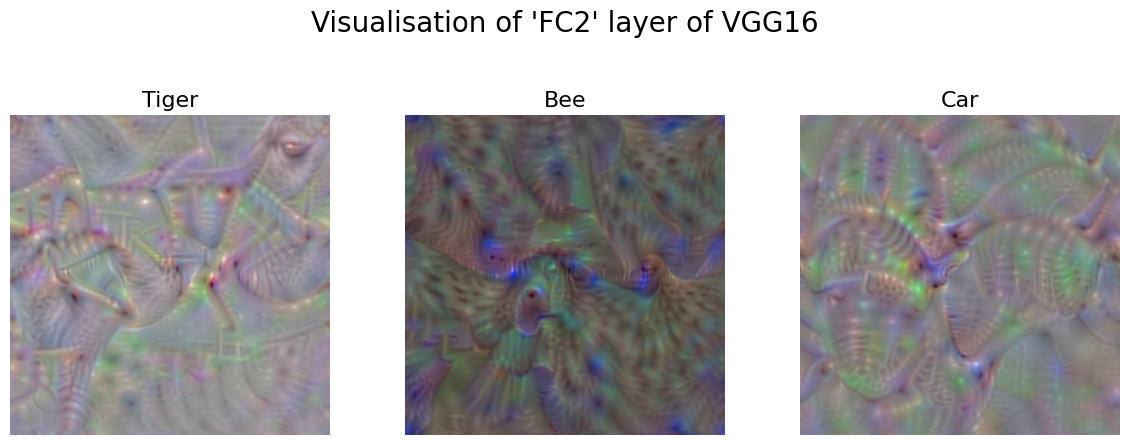

CPU times: user 24.5 s, sys: 1.22 s, total: 25.7 s
Wall time: 27.1 s


In [9]:
# fc2
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("fc2"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
f.suptitle("Visualisation of 'FC2' layer of VGG16", y=1.1, fontsize=20)
for i, title in enumerate(image_titles):
    normalized_image = activations[i] - np.min(activations[i])
    normalized_image /= np.max(normalized_image)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(normalized_image)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

200/200 [==============================] - 25s 124ms/step - Score: 59.5363 - TotalVariation2D: 6.5723 - Norm: 38.0683


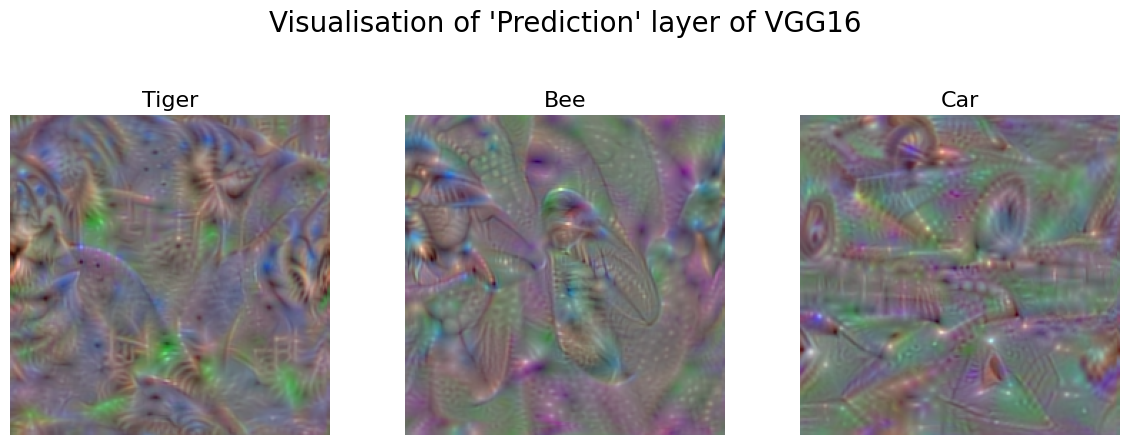

CPU times: user 24.8 s, sys: 1.06 s, total: 25.9 s
Wall time: 26.8 s


In [10]:
# predictions
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("predictions"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
f.suptitle("Visualisation of 'Prediction' layer of VGG16", y=1.1, fontsize=20)
for i, title in enumerate(image_titles):
    normalized_image = activations[i] - np.min(activations[i])
    normalized_image /= np.max(normalized_image)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(normalized_image)
    ax[i].axis('off')
plt.tight_layout()
plt.show()